In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

# Configurações para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

## Definindo as covariáveis

Iremos utilizar a covariável básica de trend, em conjunto com a indicadora mensal, e por fim, adicionar o lag de 1 semana em conjunto com um lag de 52 semanas (1 ano), para tentar capturar a sazonalidade da série.

In [2]:
# Carregando os dados originais
data = pd.read_csv("../data.csv")
data["week"] = pd.to_datetime(data["week"])
data_series = data.set_index("week")['volume']

# --- Definição de Atributos ---
df = pd.DataFrame({'volume': data_series})
df['trend'] = range(len(df))

df['month'] = df.index.month
df = pd.get_dummies(df, columns=['month'], drop_first=True, prefix='mes')
dummy_cols = [col for col in df.columns if 'mes_' in col]
df[dummy_cols] = df[dummy_cols].astype(int)

df['lag_1'] = df['volume'].shift(1)
df['lag_52'] = df['volume'].shift(52)
df.dropna(inplace=True)

X = df.drop('volume', axis=1)
y = df['volume']

In [3]:
# Divisão cronológica dos dados
train_size_full = len(data_series)
train_size_adjusted = int(train_size_full * 0.8) - 52

X_train, X_test = X.iloc[:train_size_adjusted], X.iloc[train_size_adjusted:]
y_train, y_test = y.iloc[:train_size_adjusted], y.iloc[train_size_adjusted:]

train_volume = data_series.iloc[: int(train_size_full * 0.8)]
test_volume = data_series.iloc[int(train_size_full * 0.8) :]

## Gerando as predições dos 3 modelos

In [4]:
predictions = {}
models = {}

# --- Modelo 1: Apenas Tendência ---
X_train_trend = sm.add_constant(X_train[['trend']])
X_test_trend = sm.add_constant(X_test[['trend']])
model_trend = sm.OLS(y_train, X_train_trend).fit()
predictions['Regressão com Tendência'] = model_trend.predict(X_test_trend)
models['Regressão com Tendência'] = model_trend

# --- Modelo 2: Tendência + Sazonalidade (Meses) ---
cols_sazonais = ['trend'] + [col for col in X_train.columns if 'mes_' in col]
X_train_sazonal = sm.add_constant(X_train[cols_sazonais])
X_test_sazonal = sm.add_constant(X_test[cols_sazonais])
model_sazonal = sm.OLS(y_train, X_train_sazonal).fit()
predictions['Regressão Sazonal'] = model_sazonal.predict(X_test_sazonal)
models['Regressão Sazonal'] = model_sazonal

# --- Modelo 3: Tendência + Sazonalidade + Lags ---
X_train_full = sm.add_constant(X_train)
X_test_full = sm.add_constant(X_test)
model_full = sm.OLS(y_train, X_train_full).fit()
predictions['Regressão Completa'] = model_full.predict(X_test_full)
models['Regressão Completa'] = model_full

In [5]:
# Função para o Winkler Score
def winkler_score(y_true, lower, upper, alpha):
    score = np.where(
        y_true < lower,
        (upper - lower) + (2 / alpha) * (lower - y_true),
        np.where(
            y_true > upper,
            (upper - lower) + (2 / alpha) * (y_true - upper),
            (upper - lower),
        ),
    )
    return np.mean(score)


# Função para o Erro de Quantil
def quantile_score(y_true, quantile_forecast, p):
    error = y_true - quantile_forecast
    return np.mean(np.where(error >= 0, p * error, (p - 1) * error))


# Função para o CRPS de uma distribuição Normal
def crps_gaussian(y_true, mu, sigma):
    z = (y_true - mu) / sigma
    crps = sigma * (
        z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi)
    )
    return np.mean(crps)

## Analisando as métricas das predições de cada modelo

In [6]:
alpha = 0.05
intervals = {}
residuals_std = {}

# Desvio Padrão dos resíduos de cada modelo
for name, model in models.items():
    residuals_std[name] = model.resid.std()

# Calculando os intervalos de previsão
for name, forecast in predictions.items():
    sigma = residuals_std[name]
    z_score = norm.ppf(1 - alpha / 2)
    intervals[name] = {
        'lower': forecast - z_score * sigma,
        'upper': forecast + z_score * sigma,
    }

# --- Cálculo das Métricas ---
results_list = []
m = 52  # Sazonalidade
scale = np.mean(np.abs(train_volume.diff(m).dropna()))
quantiles_to_check = [0.1, 0.25, 0.5, 0.75, 0.9]

for name, forecast in predictions.items():
    current_test_volume = test_volume[forecast.index]
    interval = intervals[name]
    sigma = residuals_std[name]

    mae = mean_absolute_error(current_test_volume, forecast)
    rmse = np.sqrt(mean_squared_error(current_test_volume, forecast))
    mape = mean_absolute_percentage_error(current_test_volume, forecast)
    mase = mae / scale

    winkler = winkler_score(
        current_test_volume, interval['lower'], interval['upper'], alpha
    )

    sigma_h = pd.Series(sigma, index=current_test_volume.index)
    crps = crps_gaussian(current_test_volume, forecast, sigma_h)

    avg_quantile_loss = []
    for p in quantiles_to_check:
        quantile_forecast = norm.ppf(p, loc=forecast, scale=sigma_h)
        avg_quantile_loss.append(
            quantile_score(current_test_volume, quantile_forecast, p)
        )

    results_list.append(
        {
            'Modelo': name,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape * 100,
            'MASE': mase,
            'Winkler Score': winkler,
            'Avg Quantile Score': np.mean(avg_quantile_loss),
            'CRPS': crps,
        }
    )

results_df = pd.DataFrame(results_list).set_index('Modelo')
print("\n--- Tabela Comparativa de Métricas (Modelos de Regressão) ---")
results_df.round(4)


--- Tabela Comparativa de Métricas (Modelos de Regressão) ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Regressão com Tendência,3.8946,4.5709,33.8018,1.1582,43.7079,1.4785,2.9736
Regressão Sazonal,2.1544,3.0993,18.0890,0.6407,49.1334,0.9226,1.8513
Regressão Completa,1.8126,2.1515,18.1892,0.5390,33.7599,0.7549,1.5082


Pelos resultados podemos observar que o modelo completo (tendência + sazonalidade + lags) apresentou o melhor desempenho, com o menor MAE, RMSE, e MAPE muito próximo do melhor modelo nessa métrica. Indicando como a adição dos lags melhorou a capacidade preditiva do modelo.

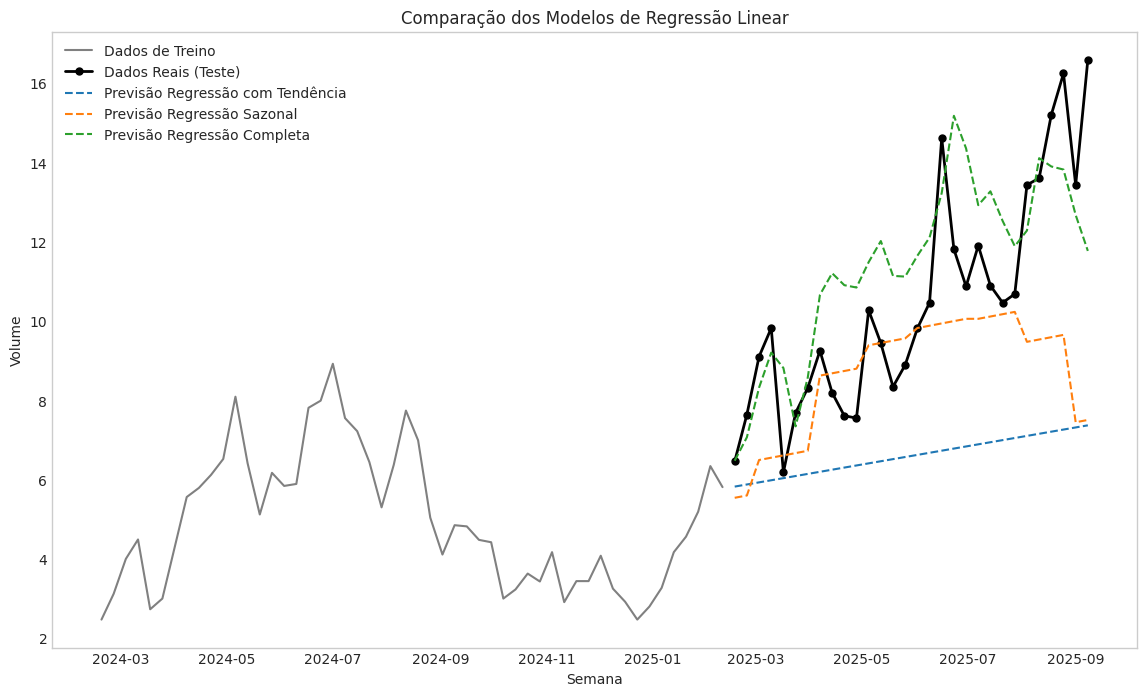

In [7]:
# Visualização e Avaliação Final

plt.figure(figsize=(14, 8))
plt.plot(y_train.iloc[-52:], label='Dados de Treino', color='gray')

plt.plot(
    y_test,
    label='Dados Reais (Teste)',
    color='black',
    linewidth=2,
    marker='o',
    markersize=5,
)

for name, forecast in predictions.items():
    plt.plot(forecast, label=f'Previsão {name}', linestyle='--')

plt.title('Comparação dos Modelos de Regressão Linear')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend(loc='upper left')
plt.grid(False)

plt.show()

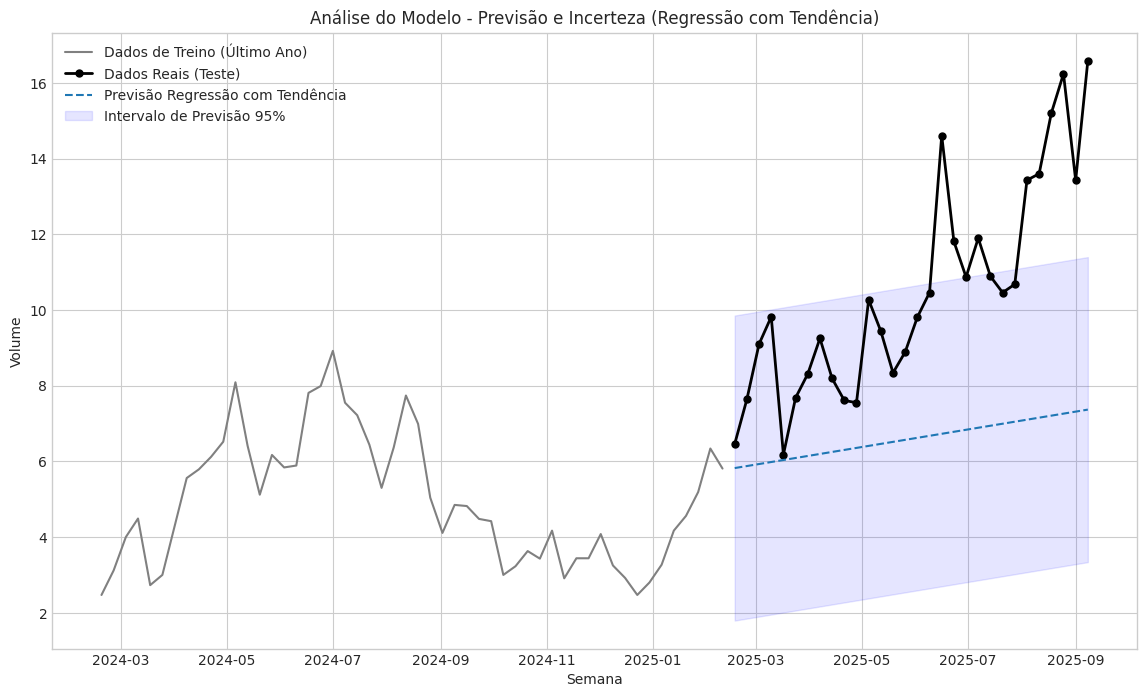

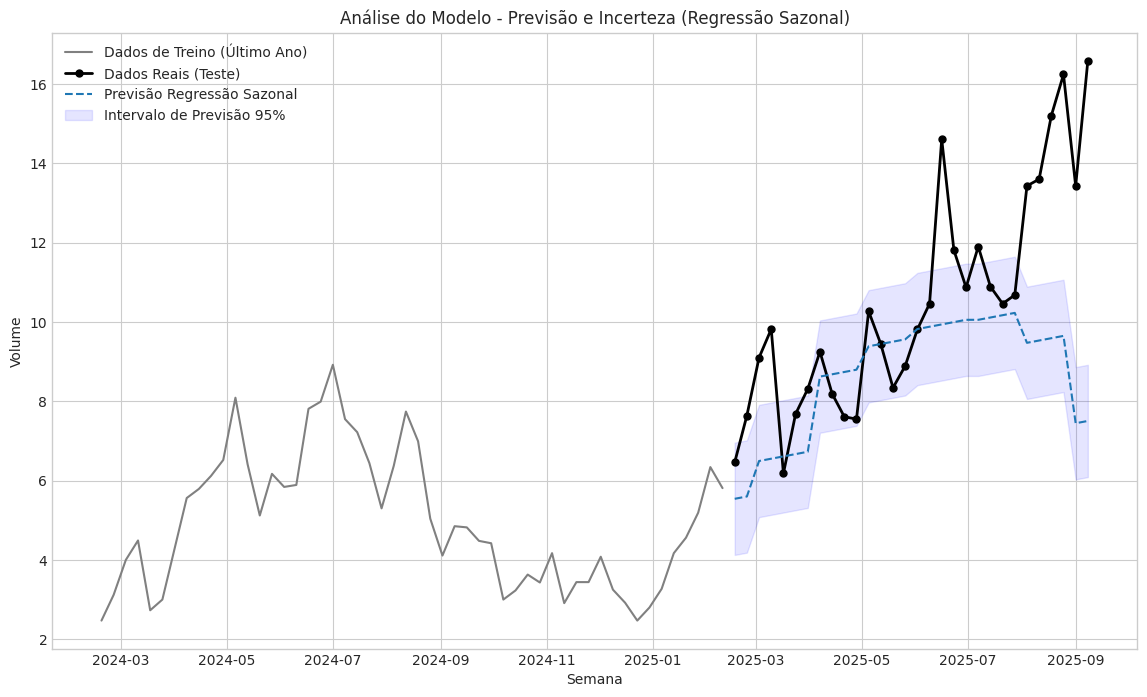

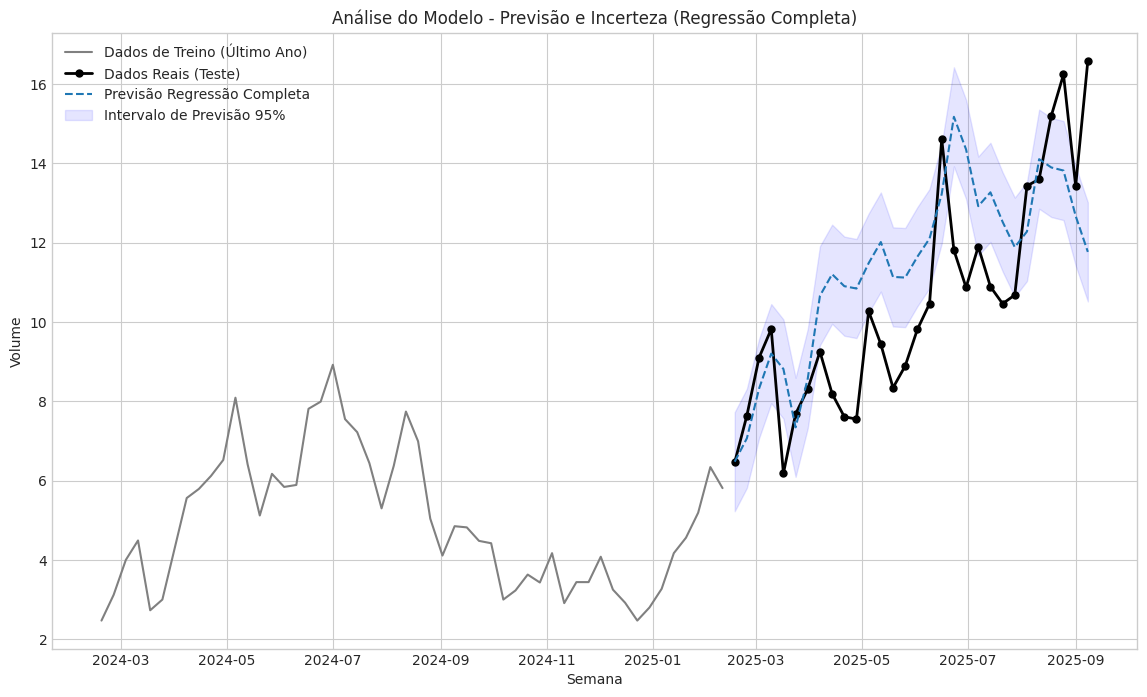

In [8]:
model_names = [
    'Regressão com Tendência',
    'Regressão Sazonal',
    'Regressão Completa',
]

for name in model_names:
    plt.figure(figsize=(14, 8))

    plt.plot(
        y_train.iloc[-52:], label='Dados de Treino (Último Ano)', color='gray'
    )
    plt.plot(
        y_test,
        label='Dados Reais (Teste)',
        color='black',
        linewidth=2,
        marker='o',
        markersize=5,
    )

    forecast_to_plot = predictions[name]
    interval_to_plot = intervals[name]

    plt.plot(forecast_to_plot, label=f'Previsão {name}', linestyle='--')

    plt.fill_between(
        interval_to_plot['lower'].index,
        interval_to_plot['lower'],
        interval_to_plot['upper'],
        color='blue',
        alpha=0.1,
        label='Intervalo de Previsão 95%',
    )

    plt.title(f'Análise do Modelo - Previsão e Incerteza ({name})')
    plt.xlabel('Semana')
    plt.ylabel('Volume')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.show()

Por fim, vemos que mesmo que este seja o melhor modelo em relação as métricas, ele ainda não é capaz de capturar todos os picos e vales da série temporal em seu intervalo de 95% de confiança.